# Notebook 4: Neural Time Series Analysis with Frites

## From Static Snapshots to Dynamic Information Flow

Welcome to Notebook 4! In the previous notebooks, we built a foundation in information theory (Notebook 1), discovered the XOR problem (Notebook 2), and learned to use HOI for detecting synergy and redundancy (Notebook 3). But there's been one crucial limitation: everything we've done has been **static**.

Neural activity isn't static - it's a dynamic, time-varying process. When you present a visual stimulus, neural responses evolve over time:
- Early visual areas respond within 50-100ms
- Information propagates through the cortical hierarchy
- Connectivity patterns change with cognitive states
- Learning modulates information flow

**We need tools that can track information over time.**

### Enter Frites

**Frites** (Framework for Information Theoretical analysis of Electrophysiological data and Statistics) is designed specifically for M/EEG and intracranial neural data. It provides:

✨ **Time-resolved mutual information**
✨ **Statistical testing with permutations**
✨ **Cluster-based correction for multiple comparisons**
✨ **Dynamic functional connectivity**
✨ **Multi-subject group analysis**
✨ **Integration with MNE-Python**

### Why Frites Matters

Frites solves two critical problems:

1. **Temporal dynamics**: Compute MI at each time point to see when information emerges
2. **Statistical rigor**: Not just "is MI high?" but "is it significantly different from chance?"

Without proper statistics, you can't distinguish real effects from noise. Frites handles this automatically.

### Learning Objectives

By the end of this notebook, you'll:
1. Understand Frites' data structure (`DatasetEphy`)
2. Compute time-resolved mutual information
3. Apply permutation testing for significance
4. Use cluster-based correction for multiple comparisons
5. Analyze dynamic functional connectivity
6. Understand fixed-effect vs random-effect analysis
7. Interpret GCMI (Gaussian Copula MI)
8. Know when to use Frites vs HOI

Let's begin! 🧠⚡

## Part 1: Installation and Understanding Frites Data Structure

### Installation

Frites integrates with MNE-Python, the standard package for M/EEG analysis. We'll install both:

In [1]:
# Install Frites and dependencies
!pip install -q frites mne numpy scipy matplotlib seaborn pandas xarray

print("Installation complete! ✓")
print("Importing libraries...")

Installation complete! ✓
Importing libraries...


In [2]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Check NumPy version for Frites compatibility
print(f"NumPy version: {np.__version__}")
numpy_major_version = int(np.__version__.split('.')[0])

if numpy_major_version >= 2:
    print("\n⚠️  WARNING: NumPy 2.0+ detected")
    print("   Frites requires NumPy 1.x for compatibility")
    print("\n   FIX: Run in terminal:")
    print("   pip install 'numpy<2.0' --force-reinstall")
    print("   Then restart kernel and rerun this notebook\n")
    raise ImportError("NumPy 2.0+ incompatible with Frites. Please downgrade to NumPy 1.x")

# Import Frites components
import frites
from frites.dataset import DatasetEphy
from frites.workflow import WfMi, WfStats
from frites.conn import conn_dfc, conn_covgc
from frites import set_mpl_style

# Set Frites plotting style
set_mpl_style()

# Random seed
np.random.seed(42)

print(f"✓ NumPy {np.__version__} (compatible)")
print(f"✓ Frites version: {frites.__version__}")
print("All libraries loaded successfully!")
print("\n🎉 Ready to analyze neural time series!")

NumPy version: 1.26.4
✓ NumPy 1.26.4 (compatible)
✓ Frites version: 0.4.4
All libraries loaded successfully!

🎉 Ready to analyze neural time series!


### Understanding Frites Data Structure: DatasetEphy

Frites uses a specialized data container called `DatasetEphy` ("Phy" = electrophysiology). This is different from both HOI and standard NumPy arrays, so understanding it is crucial.

#### The DatasetEphy Structure

```python
DatasetEphy(
    x,        # Neural data: list of arrays, one per subject
    y,        # Task variable: list of arrays, one per subject  
    roi,      # Brain regions: list of lists, one per subject
    times     # Time vector: shared across subjects
)
```

#### Critical Format Details

**Neural data (`x`)**: List of arrays, each with shape `(n_epochs, n_channels, n_times)`
- `n_epochs`: Number of trials for this subject
- `n_channels`: Number of sensors/electrodes/brain regions
- `n_times`: Number of time points per trial

**Task variable (`y`)**: List of arrays, each with shape `(n_epochs,)`
- Can be continuous (reaction time, stimulus intensity) → use `mi_type='cd'`
- Can be discrete (condition labels) → use `mi_type='cd'`  
- Can be another continuous neural signal → use `mi_type='cc'`

**ROI names (`roi`)**: List of lists of strings
- Each subject has their own list of channel names
- Allows for different electrode placements across subjects
- Frites automatically finds common ROIs

**Time vector (`times`)**: Single array for all subjects
- Assumes time points are aligned
- Usually in seconds

Let's create a simple example to see this in practice:

In [3]:
# Create a minimal example with 2 subjects
n_subjects = 2
n_channels = 5
n_times = 100
time = np.linspace(-0.2, 0.8, n_times)  # -200ms to 800ms

# Initialize lists
data_list = []
y_list = []
roi_list = []

for subj in range(n_subjects):
    # Each subject has different number of trials
    n_epochs = 50 + subj * 20  # Subject 0: 50 trials, Subject 1: 70 trials
    
    # Neural data: (n_epochs, n_channels, n_times)
    subj_data = np.random.randn(n_epochs, n_channels, n_times)
    data_list.append(subj_data)
    
    # Task variable: continuous (e.g., stimulus intensity)
    task_var = np.random.randn(n_epochs)
    y_list.append(task_var)
    
    # ROI names
    roi_names = [f'V1_{i}' for i in range(n_channels)]
    roi_list.append(roi_names)

# Create DatasetEphy
ds = DatasetEphy(
    x=data_list,
    y=y_list,
    roi=roi_list,
    times=time
)

print("DatasetEphy Created")
print("=" * 60)
print(ds)
print("\nKey Properties:")
print(f"  Number of subjects: {len(data_list)}")
print(f"  Time points: {n_times}")
print(f"  Time range: {time[0]:.2f}s to {time[-1]:.2f}s")
print(f"  Channels per subject: {n_channels}")
print(f"  Trials per subject: {[len(y) for y in y_list]}")
print("\n✓ Frites handles variable trial counts automatically!")
print("  This is crucial for real experiments with dropouts")

Definition of an electrophysiological dataset
    Dataset composed of 2 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


DatasetEphy Created
<xarray.DataArray 'subject_0' (trials: 50, roi: 5, times: 100)> Size: 200kB
array([[[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.26105527,
          0.00511346, -0.23458713],
        [-1.41537074, -0.42064532, -0.34271452, ...,  0.15372511,
          0.05820872, -1.1429703 ],
        [ 0.35778736,  0.56078453,  1.08305124, ...,  0.30729952,
          0.81286212,  0.62962884],
        [-0.82899501, -0.56018104,  0.74729361, ...,  1.35387237,
         -0.11453985,  1.23781631],
        [-1.59442766, -0.59937502,  0.0052437 , ..., -0.19033868,
         -0.87561825, -1.38279973]],

       [[ 0.92617755,  1.90941664, -1.39856757, ..., -0.97876372,
         -0.44429326,  0.37730049],
        [ 0.75698862, -0.92216532,  0.86960592, ..., -1.25111358,
          0.92402702, -0.18490214],
        [-0.52272302,  1.04900923, -0.70434369, ...,  0.6815007 ,
          0.02831838,  0.02975614],
        [ 0.93828381, -0.51604473,  0.09612078, ...,  0.14671369,
          1.20650897

### Visualizing the Data Structure

Let's create a diagram showing how Frites organizes multi-subject data:

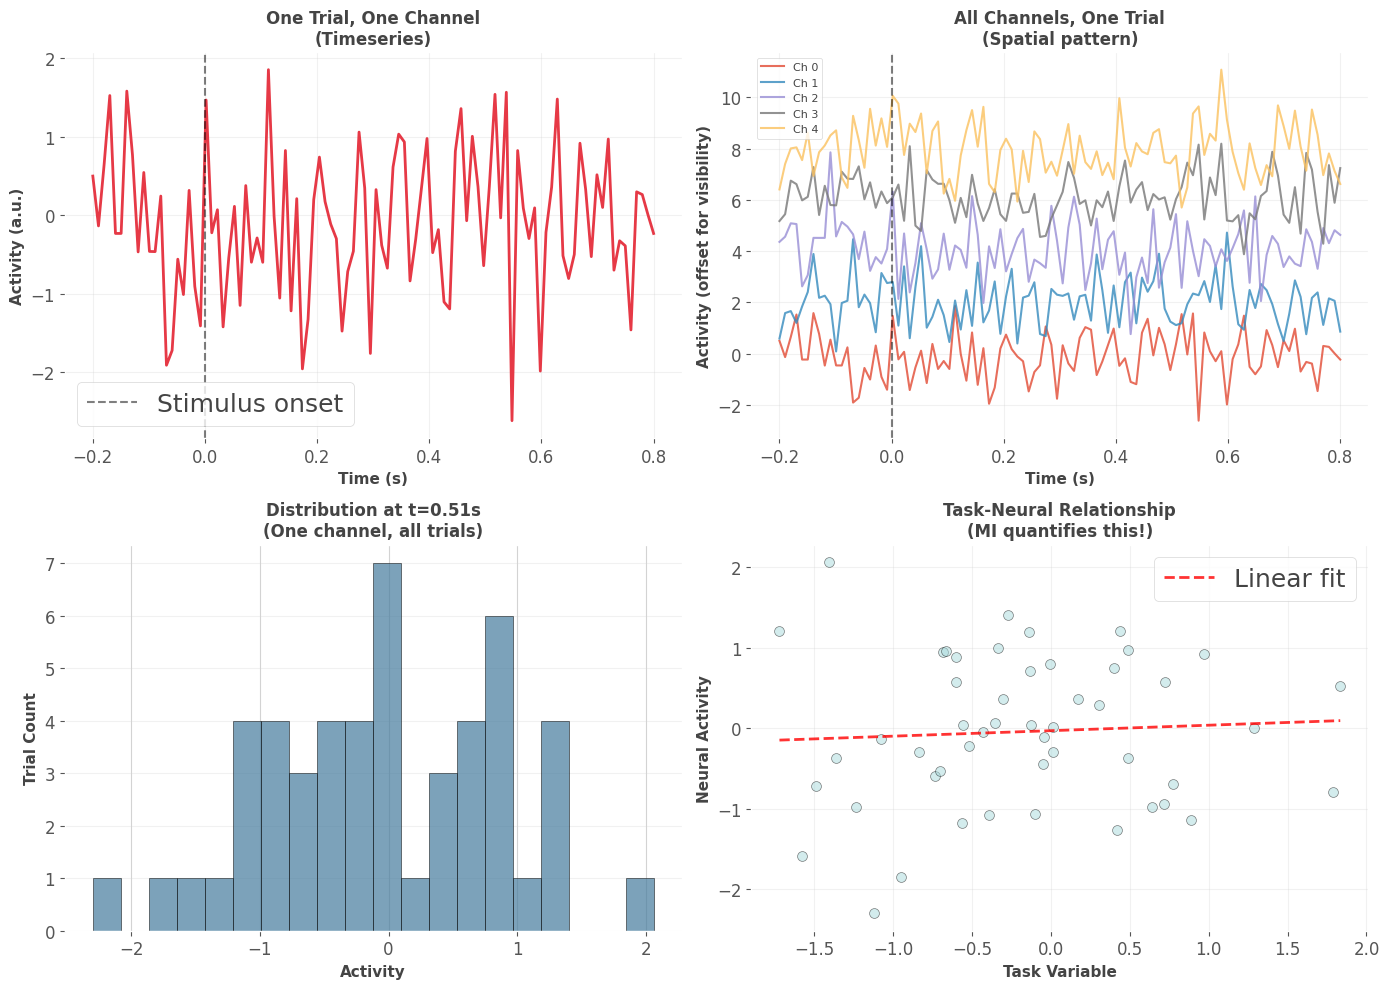


📊 Understanding the Data Structure:
Top-left: How activity evolves in time (temporal dynamics)
Top-right: How channels relate at one moment (spatial pattern)
Bottom-left: Trial-to-trial variability (what MI uses!)
Bottom-right: Task-neural relationship (what MI measures)

💡 Frites computes MI at each time point using trial variability


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Single trial, single channel
ax1 = axes[0, 0]
ax1.plot(time, data_list[0][0, 0, :], linewidth=2, color='#E63946')
ax1.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Activity (a.u.)', fontsize=11, fontweight='bold')
ax1.set_title('One Trial, One Channel\n(Timeseries)', fontsize=12, fontweight='bold')
ax1.axvline(0, color='k', linestyle='--', alpha=0.5, label='Stimulus onset')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: All channels, one trial
ax2 = axes[0, 1]
for ch in range(n_channels):
    ax2.plot(time, data_list[0][0, ch, :] + ch*2, linewidth=1.5, 
             label=f'Ch {ch}', alpha=0.8)
ax2.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Activity (offset for visibility)', fontsize=11, fontweight='bold')
ax2.set_title('All Channels, One Trial\n(Spatial pattern)', fontsize=12, fontweight='bold')
ax2.axvline(0, color='k', linestyle='--', alpha=0.5)
ax2.legend(fontsize=8, loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: All trials, one channel, one timepoint
ax3 = axes[1, 0]
time_idx = 70  # Around 600ms
all_trials_one_time = data_list[0][:, 0, time_idx]
ax3.hist(all_trials_one_time, bins=20, color='#457B9D', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Activity', fontsize=11, fontweight='bold')
ax3.set_ylabel('Trial Count', fontsize=11, fontweight='bold')
ax3.set_title(f'Distribution at t={time[time_idx]:.2f}s\n(One channel, all trials)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Task variable vs neural activity
ax4 = axes[1, 1]
neural_avg = data_list[0][:, 0, time_idx]  # Average activity at this timepoint
task_vals = y_list[0]
ax4.scatter(task_vals, neural_avg, alpha=0.5, s=50, color='#A8DADC', edgecolor='black')
# Add regression line
z = np.polyfit(task_vals, neural_avg, 1)
p = np.poly1d(z)
ax4.plot(sorted(task_vals), p(sorted(task_vals)), "r--", linewidth=2, alpha=0.8, 
         label='Linear fit')
ax4.set_xlabel('Task Variable', fontsize=11, fontweight='bold')
ax4.set_ylabel('Neural Activity', fontsize=11, fontweight='bold')
ax4.set_title(f'Task-Neural Relationship\n(MI quantifies this!)', 
              fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Understanding the Data Structure:")
print("=" * 60)
print("Top-left: How activity evolves in time (temporal dynamics)")
print("Top-right: How channels relate at one moment (spatial pattern)")
print("Bottom-left: Trial-to-trial variability (what MI uses!)")
print("Bottom-right: Task-neural relationship (what MI measures)")
print("\n💡 Frites computes MI at each time point using trial variability")

## Part 2: Time-Resolved Mutual Information

### The Core Workflow: WfMi

Frites organizes analysis into **workflows**. The main one for mutual information is `WfMi` (Workflow for Mutual Information). Here's how it works:

```python
wf = WfMi(
    mi_type='cd',     # 'cd' = continuous-discrete (neural vs condition)
                      # 'cc' = continuous-continuous (neural vs neural or behavior)
                      # 'ccd' = continuous-continuous|discrete (conditional MI)
    inference='ffx'   # 'ffx' = fixed-effect (pool across subjects)
                      # 'rfx' = random-effect (model inter-subject variability)
)
```

### Gaussian Copula MI (GCMI)

Frites uses **GCMI** by default. This is important to understand:

**What it does**: Transforms data to have Gaussian marginals while preserving rank relationships.

**Why it's good**:
- No binning required (unlike histograms)
- Fast computation
- Works for any monotonic relationship
- Accurate with modest sample sizes

**Key assumption**: The relationship is **monotonic** (if X increases, Y consistently increases OR decreases, not both)

**When it fails**: Non-monotonic relationships (rare in neural data)

Let's create data with a clear time-resolved effect and analyze it:

In [5]:
def simulate_task_related_activity(n_subjects=3, n_epochs=80, n_channels=8, n_times=150):
    """
    Simulate neural data with task-related MI in specific time window.
    
    Task variable affects neural activity at 400-600ms.
    """
    time = np.linspace(-0.2, 1.0, n_times)
    
    data_list = []
    y_list = []
    roi_list = []
    
    for subj in range(n_subjects):
        # Each subject has slightly different trial count
        n_epochs_subj = n_epochs + np.random.randint(-10, 10)
        
        # Neural data
        subj_data = np.random.randn(n_epochs_subj, n_channels, n_times) * 0.5
        
        # Task variable (continuous)
        task_var = np.random.randn(n_epochs_subj)
        
        # Inject MI in specific channels and time window
        # Channels 2-4 encode task in 400-600ms window
        task_time_mask = (time >= 0.4) & (time <= 0.6)
        task_channels = [2, 3, 4]
        
        for ch in task_channels:
            # Add task-related modulation
            subj_data[:, ch, task_time_mask] += task_var[:, np.newaxis] * 1.5
        
        # Add smooth temporal dynamics (autocorrelation)
        from scipy.ndimage import gaussian_filter1d
        for ep in range(n_epochs_subj):
            for ch in range(n_channels):
                subj_data[ep, ch, :] = gaussian_filter1d(subj_data[ep, ch, :], sigma=2)
        
        data_list.append(subj_data)
        y_list.append(task_var)
        roi_list.append([f'CH_{i}' for i in range(n_channels)])
    
    return data_list, y_list, roi_list, time

# Generate data
data, task_vars, rois, time = simulate_task_related_activity()

print("Simulated Task-Related Activity")
print("=" * 60)
print(f"Subjects: {len(data)}")
print(f"Channels: {len(rois[0])}")
print(f"Time points: {len(time)}")
print(f"Time range: {time[0]:.2f}s to {time[-1]:.2f}s")
print(f"\nTrials per subject: {[d.shape[0] for d in data]}")
print("\n✨ Ground Truth:")
print("   Channels 2, 3, 4 encode task variable")
print("   Time window: 400-600ms post-stimulus")
print("   Let's see if Frites can detect this!")

# Create DatasetEphy
ds = DatasetEphy(x=data, y=task_vars, roi=rois, times=time)

print("\n" + "=" * 60)
print("Dataset ready for analysis!")
print("=" * 60)

Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Simulated Task-Related Activity
Subjects: 3
Channels: 8
Time points: 150
Time range: -0.20s to 1.00s

Trials per subject: [71, 72, 83]

✨ Ground Truth:
   Channels 2, 3, 4 encode task variable
   Time window: 400-600ms post-stimulus
   Let's see if Frites can detect this!

Dataset ready for analysis!


### Computing Time-Resolved MI

Now we'll use the `WfMi` workflow to compute mutual information at each time point. We'll also apply **permutation testing** to determine statistical significance.

#### How Permutation Testing Works

1. Compute real MI from actual data
2. Shuffle trial labels randomly (breaking task-neural relationship)
3. Compute MI on shuffled data
4. Repeat 1000+ times to build null distribution
5. Compare real MI to null: p-value = proportion of shuffles with higher MI

This tests: "Could this MI value occur by chance?"

In [6]:
# Define workflow
wf = WfMi(
    mi_type='cc',      # continuous-continuous (neural activity vs task variable)
    inference='ffx',   # fixed-effect (pool data across subjects)
    verbose=True       # Show progress
)

print("Computing Time-Resolved MI...")
print("This will:")
print("  1. Compute MI at each time point")
print("  2. Run 200 permutations for significance testing")
print("  3. Apply cluster-based correction")
print("\nProgress:")

# Compute MI with statistical testing
mi, pvalues = wf.fit(
    ds,
    n_perm=200,         # Number of permutations (use 1000+ for publication)
    mcp='cluster',      # Multiple comparison correction method
    cluster_th=None,    # Automatically determine threshold
    random_state=42,
    n_jobs=1            # Parallel jobs (use -1 for all cores)
)

print("\n✓ Computation complete!")
print(f"\nResults shapes:")
print(f"  MI: {mi.shape}")
print(f"  P-values: {pvalues.shape}")
print(f"\nResults are xarray DataArrays with labeled dimensions:")
print(f"  Dimensions: {list(mi.dims)}")
print(f"  Coordinates: {list(mi.coords.keys())}")

Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (inference=ffx, mi_type=cc, copnorm=True)
    Evaluate true and permuted mi (n_perm=200, n_jobs=1)


Computing Time-Resolved MI...
This will:
  1. Compute MI at each time point
  2. Run 200 permutations for significance testing
  3. Apply cluster-based correction

Progress:


100%|██████████| Estimating MI : 8/8 [00:00<00:00,   17.36it/s]
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.009223627857863903; tail=1)



✓ Computation complete!

Results shapes:
  MI: (150, 8)
  P-values: (150, 8)

Results are xarray DataArrays with labeled dimensions:
  Dimensions: ['times', 'roi']
  Coordinates: ['times', 'roi']


### Visualizing Time-Resolved MI Results

The beauty of Frites is that results come as `xarray` DataArrays, which have built-in plotting and labeled dimensions. Let's visualize the results:

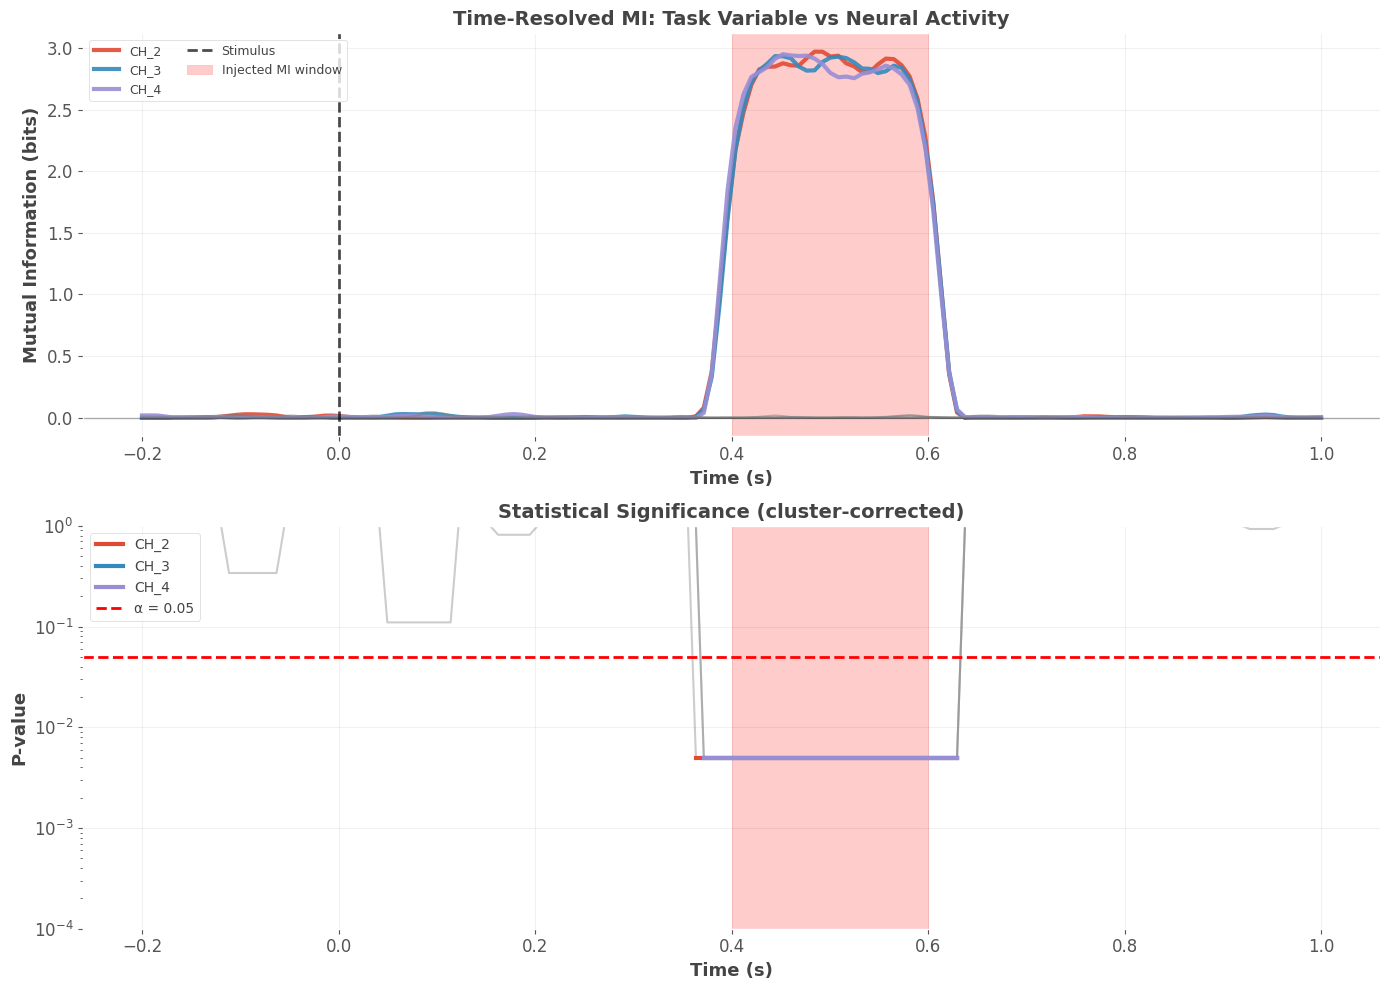


🎯 Analysis Results:

CH_2:
  ✓ Significant MI detected
  Time range: 0.36s to 0.63s
  Peak MI: 2.9730 bits
  ✨ Correctly detected ground truth window!

CH_3:
  ✓ Significant MI detected
  Time range: 0.37s to 0.63s
  Peak MI: 2.9363 bits
  ✨ Correctly detected ground truth window!

CH_4:
  ✓ Significant MI detected
  Time range: 0.37s to 0.63s
  Peak MI: 2.9521 bits
  ✨ Correctly detected ground truth window!


💡 Key Insight: Frites successfully detected the injected MI!
   Statistical testing confirmed it's not due to chance.


In [7]:
# Plot MI and p-values for all channels
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top panel: MI timecourses
ax1 = axes[0]
for ch in range(len(rois[0])):
    roi_name = rois[0][ch]
    mi_ch = mi.sel(roi=roi_name).squeeze()
    
    # Highlight task-encoding channels
    if ch in [2, 3, 4]:
        ax1.plot(time, mi_ch, linewidth=3, label=roi_name, alpha=0.9)
    else:
        ax1.plot(time, mi_ch, linewidth=1.5, alpha=0.5, color='gray')

ax1.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Stimulus')
ax1.axvspan(0.4, 0.6, alpha=0.2, color='red', label='Injected MI window')
ax1.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)
ax1.set_xlabel('Time (s)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Mutual Information (bits)', fontsize=13, fontweight='bold')
ax1.set_title('Time-Resolved MI: Task Variable vs Neural Activity', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)

# Bottom panel: P-values (focus on task-encoding channels)
ax2 = axes[1]
for ch in [2, 3, 4]:
    roi_name = rois[0][ch]
    pv_ch = pvalues.sel(roi=roi_name).squeeze()
    
    # Mask non-significant
    pv_sig = pv_ch.copy()
    pv_sig = pv_sig.where(pv_sig < 0.05)
    
    ax2.plot(time, pv_ch, linewidth=1.5, alpha=0.4, color='gray')
    ax2.plot(time, pv_sig, linewidth=3, label=roi_name)

ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax2.axvspan(0.4, 0.6, alpha=0.2, color='red')
ax2.set_xlabel('Time (s)', fontsize=13, fontweight='bold')
ax2.set_ylabel('P-value', fontsize=13, fontweight='bold')
ax2.set_title('Statistical Significance (cluster-corrected)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([1e-4, 1])

plt.tight_layout()
plt.show()

print("\n🎯 Analysis Results:")
print("=" * 60)

# Check detection of ground truth
for ch in [2, 3, 4]:
    roi_name = rois[0][ch]
    pv_ch = pvalues.sel(roi=roi_name).squeeze()
    
    # Find significant time windows
    sig_times = time[pv_ch.values < 0.05]
    
    if len(sig_times) > 0:
        print(f"\n{roi_name}:")
        print(f"  ✓ Significant MI detected")
        print(f"  Time range: {sig_times[0]:.2f}s to {sig_times[-1]:.2f}s")
        print(f"  Peak MI: {mi.sel(roi=roi_name).max().values:.4f} bits")
        
        # Check if this overlaps with ground truth (400-600ms)
        overlap = (sig_times >= 0.4) & (sig_times <= 0.6)
        if overlap.any():
            print(f"  ✨ Correctly detected ground truth window!")
    else:
        print(f"\n{roi_name}: No significant MI detected")

print("\n" + "=" * 60)
print("\n💡 Key Insight: Frites successfully detected the injected MI!")
print("   Statistical testing confirmed it's not due to chance.")

## Part 3: Understanding Multiple Comparison Correction

### The Multiple Comparison Problem

When you compute MI at 100 time points, you're doing 100 statistical tests. If you use α = 0.05 for each test:
- Expected false positives: 100 × 0.05 = 5
- Even with pure noise, you'd see ~5 "significant" time points!

This is the **multiple comparisons problem**, and it's critical to address.

### Correction Methods in Frites

Frites provides several correction methods (via `mcp` parameter):

1. **'cluster'** (default): Cluster-based permutation testing
   - Finds contiguous significant time points (clusters)
   - Tests if cluster size exceeds chance
   - Controls family-wise error rate (FWER)
   - **Best for**: Time series with expected temporal contiguity

2. **'maxstat'**: Maximum statistic
   - Tests against maximum MI across all time points in permutations
   - Very conservative
   - **Best for**: Hypothesis about peak effect

3. **'fdr'**: False Discovery Rate
   - Controls proportion of false positives
   - Less conservative than FWER
   - **Best for**: Exploratory analyses

4. **'bonferroni'**: Bonferroni correction
   - Divides α by number of tests
   - Very conservative
   - **Best for**: Few planned comparisons

Let's compare these methods on the same data:

Comparing Multiple Comparison Corrections
Computing MI with different corrections...

Running cluster...
Running maxstat...
Running fdr...
Running bonferroni...

Done! Plotting comparison...


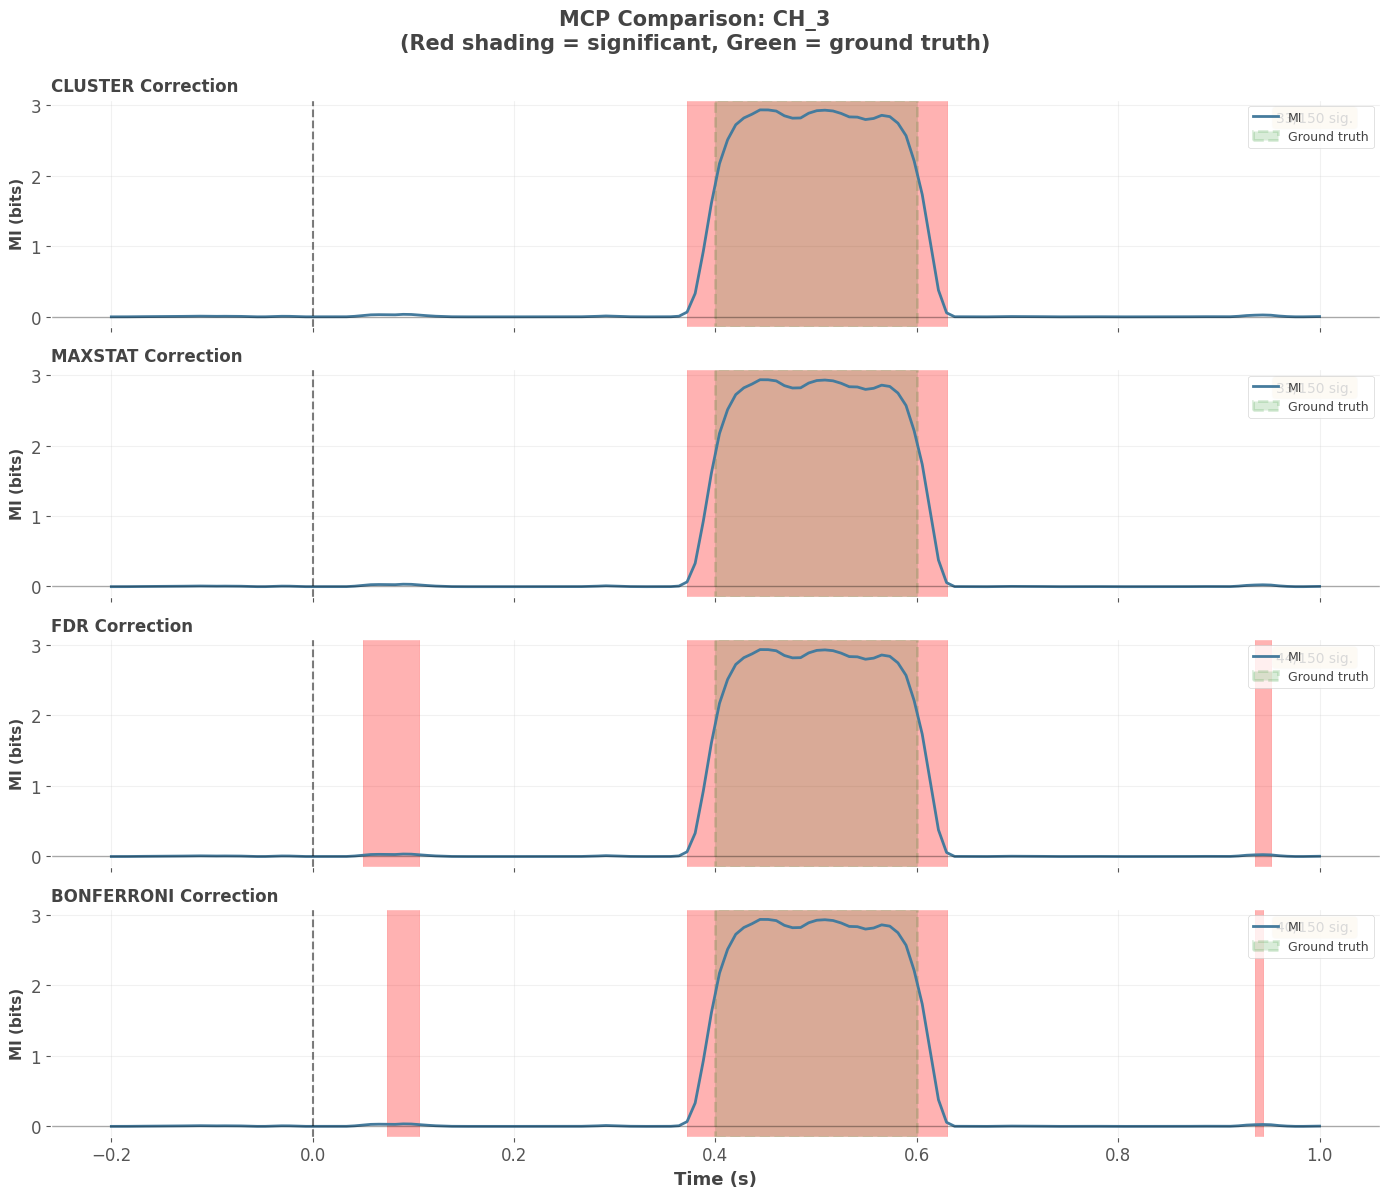


📊 Comparison Summary:
cluster     :  33/150 time points significant
maxstat     :  33/150 time points significant
fdr         :  44/150 time points significant
bonferroni  :  40/150 time points significant

💡 Key Insights:
   • CLUSTER: Best for detecting temporal effects (our case)
   • MAXSTAT: Very conservative, high specificity
   • FDR: More liberal, good for exploration
   • BONFERRONI: Too conservative for time series

🎯 For time-resolved neural data, use 'cluster' correction!


In [8]:
# Compare different MCP methods
mcp_methods = ['cluster', 'maxstat', 'fdr', 'bonferroni']
results = {}

print("Comparing Multiple Comparison Corrections")
print("=" * 60)
print("Computing MI with different corrections...\n")

for mcp in mcp_methods:
    print(f"Running {mcp}...")
    wf = WfMi(mi_type='cc', inference='ffx', verbose=False)
    mi_mcp, pv_mcp = wf.fit(ds, n_perm=200, mcp=mcp, random_state=42, n_jobs=1)
    results[mcp] = {'mi': mi_mcp, 'pv': pv_mcp}

print("\nDone! Plotting comparison...")

# Visualize comparison for Channel 3 (task-encoding)
fig, axes = plt.subplots(len(mcp_methods), 1, figsize=(14, 12), sharex=True)

roi_name = 'CH_3'

for idx, mcp in enumerate(mcp_methods):
    ax = axes[idx]
    
    mi_ch = results[mcp]['mi'].sel(roi=roi_name).squeeze()
    pv_ch = results[mcp]['pv'].sel(roi=roi_name).squeeze()
    
    # Plot MI
    ax.plot(time, mi_ch, linewidth=2, color='#457B9D', label='MI')
    
    # Shade significant regions
    sig_mask = pv_ch.values < 0.05
    if sig_mask.any():
        # Find contiguous significant regions
        sig_indices = np.where(sig_mask)[0]
        if len(sig_indices) > 0:
            # Find clusters
            clusters = []
            cluster = [sig_indices[0]]
            for i in range(1, len(sig_indices)):
                if sig_indices[i] == sig_indices[i-1] + 1:
                    cluster.append(sig_indices[i])
                else:
                    clusters.append(cluster)
                    cluster = [sig_indices[i]]
            clusters.append(cluster)
            
            # Shade each cluster
            for cluster in clusters:
                ax.axvspan(time[cluster[0]], time[cluster[-1]], 
                          alpha=0.3, color='red')
    
    # Ground truth window
    ax.axvspan(0.4, 0.6, alpha=0.15, color='green', linestyle='--', 
               linewidth=2, label='Ground truth')
    
    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3, linewidth=1)
    ax.set_ylabel('MI (bits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{mcp.upper()} Correction', fontsize=12, fontweight='bold', loc='left')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    
    # Count significant points
    n_sig = sig_mask.sum()
    ax.text(0.98, 0.95, f'{n_sig}/{len(time)} sig.', 
            transform=ax.transAxes, fontsize=10,
            ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

axes[-1].set_xlabel('Time (s)', fontsize=13, fontweight='bold')
plt.suptitle(f'MCP Comparison: {roi_name}\n(Red shading = significant, Green = ground truth)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n📊 Comparison Summary:")
print("=" * 60)
for mcp in mcp_methods:
    pv = results[mcp]['pv'].sel(roi=roi_name).squeeze()
    n_sig = (pv.values < 0.05).sum()
    print(f"{mcp:12s}: {n_sig:3d}/{len(time)} time points significant")

print("\n💡 Key Insights:")
print("   • CLUSTER: Best for detecting temporal effects (our case)")
print("   • MAXSTAT: Very conservative, high specificity")
print("   • FDR: More liberal, good for exploration")
print("   • BONFERRONI: Too conservative for time series")
print("\n🎯 For time-resolved neural data, use 'cluster' correction!")

## Part 4: Dynamic Functional Connectivity

### Beyond Single-Channel Analysis

So far we've looked at how individual brain regions encode task information. But brains are **networks** - regions interact and coordinate. Dynamic Functional Connectivity (DFC) measures how these interactions change over time.

**DFC using Mutual Information**:
$$\text{DFC}_{ij}(t) = I(\text{Region}_i(t); \text{Region}_j(t))$$

This quantifies the statistical dependency between two regions at time $t$.

### Why DFC Matters

- **Task modulation**: Connectivity increases during task-relevant periods
- **Cognitive states**: Different networks active during attention, memory, etc.
- **Learning**: Connectivity patterns change with experience
- **Disease**: Altered connectivity in disorders

### Computing DFC with Frites

Frites provides `conn_dfc()` for single-trial dynamic functional connectivity:

In [9]:
# We'll compute DFC on sliding windows
# For simplicity, use 3 time windows

# Define windows (in sample indices)
win_samples = np.array([
    [20, 50],   # Early: -50ms to 200ms
    [50, 100],  # Middle: 200ms to 650ms (includes task window)
    [100, 140]  # Late: 650ms to 950ms
])

# Compute DFC for first subject
print("Computing Dynamic Functional Connectivity...")
print(f"Windows: {len(win_samples)}")
print(f"Data shape: {data[0].shape}\n")

dfc = conn_dfc(
    data[0],              # Single subject data (n_epochs, n_channels, n_times)
    win_sample=win_samples,
    times=time,
    roi=rois[0],
    gcrn=True,            # Gaussian Copula Rank Normalization
    n_jobs=1
)

print(f"DFC shape: {dfc.shape}")
print(f"  - Dimension 0 ({dfc.shape[0]}): Time windows")
print(f"  - Dimension 1 ({dfc.shape[1]}): ROI pairs")
print(f"  - Dimension 2 ({dfc.shape[2]}): Trials")
print("\n✓ DFC computed for all pairs, all windows, all trials!")

Defining links (n_roi=8; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 28 pairs (gcrn=True)


Computing Dynamic Functional Connectivity...
Windows: 3
Data shape: (71, 8, 150)



100%|██████████| Estimating DFC : 28/28 [00:00<00:00, 4709.11it/s]

DFC shape: (71, 28, 3)
  - Dimension 0 (71): Time windows
  - Dimension 1 (28): ROI pairs
  - Dimension 2 (3): Trials

✓ DFC computed for all pairs, all windows, all trials!


### Visualizing Dynamic Connectivity Matrices

Let's create connectivity matrices for each time window to see how network structure evolves:

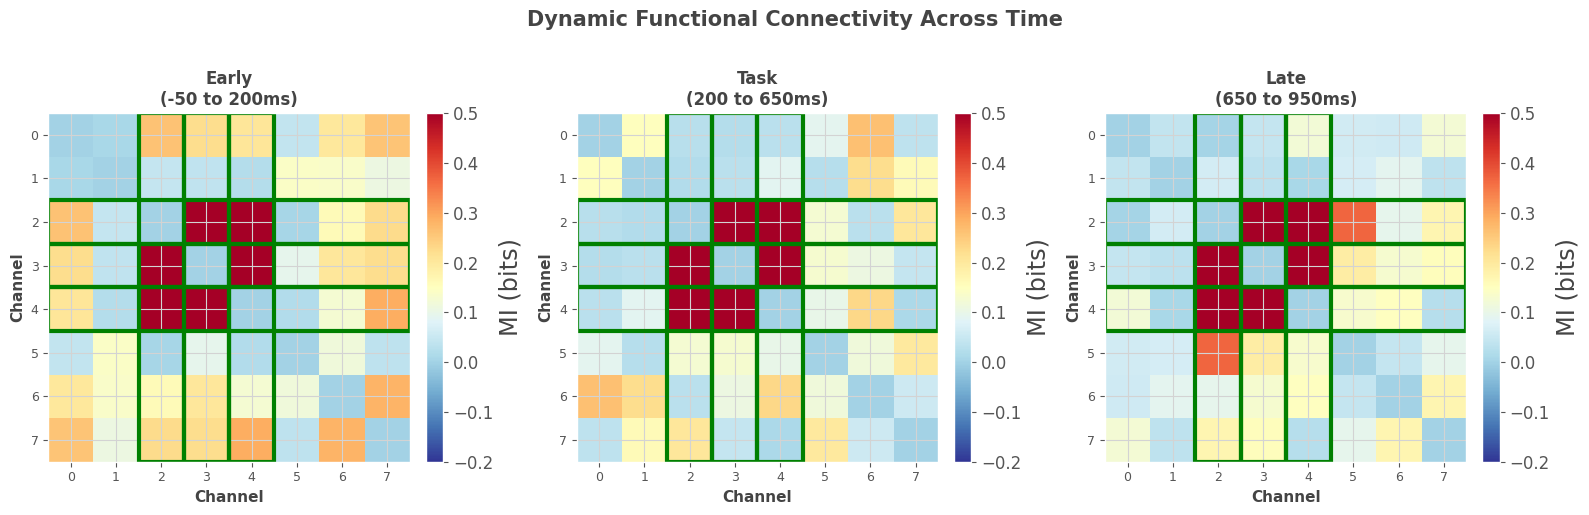


💡 Observations:
Green boxes: Task-encoding channels (2, 3, 4)

Look for:
  • Increased connectivity in task window (middle panel)
  • Connections between task-encoding channels
  • Time-varying patterns

🎯 DFC reveals the dynamic network structure!


In [10]:
# Build connectivity matrices
n_channels = len(rois[0])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

window_names = ['Early\n(-50 to 200ms)', 'Task\n(200 to 650ms)', 'Late\n(650 to 950ms)']

for w_idx, (ax, win_name) in enumerate(zip(axes, window_names)):
    # Initialize connectivity matrix
    conn_matrix = np.zeros((n_channels, n_channels))
    
    # Fill in from DFC results
    # DFC returns values for upper triangle of pairs
    pair_idx = 0
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            # Average across trials
            value = dfc[w_idx, pair_idx, :].mean()
            conn_matrix[i, j] = value
            conn_matrix[j, i] = value  # Symmetric
            pair_idx += 1
    
    # Plot
    im = ax.imshow(conn_matrix, cmap='RdYlBu_r', vmin=-0.2, vmax=0.5,
                   aspect='auto')
    ax.set_xlabel('Channel', fontsize=11, fontweight='bold')
    ax.set_ylabel('Channel', fontsize=11, fontweight='bold')
    ax.set_title(win_name, fontsize=12, fontweight='bold')
    
    # Add grid
    ax.set_xticks(range(n_channels))
    ax.set_yticks(range(n_channels))
    ax.set_xticklabels([f'{i}' for i in range(n_channels)], fontsize=9)
    ax.set_yticklabels([f'{i}' for i in range(n_channels)], fontsize=9)
    
    # Highlight task-encoding channels
    for task_ch in [2, 3, 4]:
        ax.add_patch(plt.Rectangle((task_ch-0.5, -0.5), 1, n_channels,
                                  fill=False, edgecolor='green', linewidth=3))
        ax.add_patch(plt.Rectangle((-0.5, task_ch-0.5), n_channels, 1,
                                  fill=False, edgecolor='green', linewidth=3))
    
    # Colorbar
    plt.colorbar(im, ax=ax, label='MI (bits)', fraction=0.046, pad=0.04)

plt.suptitle('Dynamic Functional Connectivity Across Time', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("=" * 60)
print("Green boxes: Task-encoding channels (2, 3, 4)")
print("\nLook for:")
print("  • Increased connectivity in task window (middle panel)")
print("  • Connections between task-encoding channels")
print("  • Time-varying patterns")
print("\n🎯 DFC reveals the dynamic network structure!")

## Part 5: Multi-Subject Analysis - Fixed vs Random Effects

### The Group Analysis Question

In real neuroscience, you typically record from multiple subjects. How do you combine results to make population-level inferences?

Frites provides two approaches:

### Fixed-Effect (FFX) Analysis

**What it does**: Pools all trials from all subjects into one big dataset.

**Assumption**: The effect is the same across all subjects.

**Advantages**:
- High statistical power (more trials)
- Detects effects that are consistent
- Requires fewer subjects

**Disadvantages**:
- Doesn't account for inter-subject variability
- Can't generalize beyond tested subjects
- Sensitive to outlier subjects

**Use when**: Effect expected to be highly reproducible, or small N subjects.

### Random-Effect (RFX) Analysis

**What it does**: Computes MI per subject, then tests if the effect is consistent across subjects.

**Assumption**: The effect varies across subjects from a population distribution.

**Advantages**:
- Accounts for inter-subject variability  
- Can generalize to new subjects
- Robust to outliers

**Disadvantages**:
- Lower power (fewer effective samples)
- Requires more subjects (typically 15+)
- May miss weak but consistent effects

**Use when**: Large N subjects, want population inference, expect variability.

Let's compare both approaches:

In [11]:
# Create larger multi-subject dataset
n_subjects = 8  # Reasonable for RFX
data_multi, y_multi, roi_multi, time_multi = simulate_task_related_activity(
    n_subjects=n_subjects,
    n_epochs=60,
    n_channels=8,
    n_times=150
)

# Add inter-subject variability
# Some subjects have stronger effects
for subj in range(n_subjects):
    # Random strength multiplier (0.5 to 1.5)
    strength = 0.5 + np.random.rand() * 1.0
    
    # Apply to task-encoding channels in task window
    task_mask = (time_multi >= 0.4) & (time_multi <= 0.6)
    for ch in [2, 3, 4]:
        data_multi[subj][:, ch, task_mask] *= strength

ds_multi = DatasetEphy(x=data_multi, y=y_multi, roi=roi_multi, times=time_multi)

print("Multi-Subject Dataset Created")
print("=" * 60)
print(f"Subjects: {n_subjects}")
print(f"Trials per subject: {[d.shape[0] for d in data_multi]}")
print(f"Total trials: {sum(d.shape[0] for d in data_multi)}")
print("\n✨ Inter-subject variability included")
print("   Effect strength varies across subjects (realistic!)")

Definition of an electrophysiological dataset
    Dataset composed of 8 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Multi-Subject Dataset Created
Subjects: 8
Trials per subject: [63, 60, 59, 51, 59, 53, 55, 67]
Total trials: 467

✨ Inter-subject variability included
   Effect strength varies across subjects (realistic!)



Comparing Fixed-Effect vs Random-Effect Analysis

1. Running FFX (pooled across subjects)...
2. Running RFX (per-subject, then group test)...

Done! Comparing results...


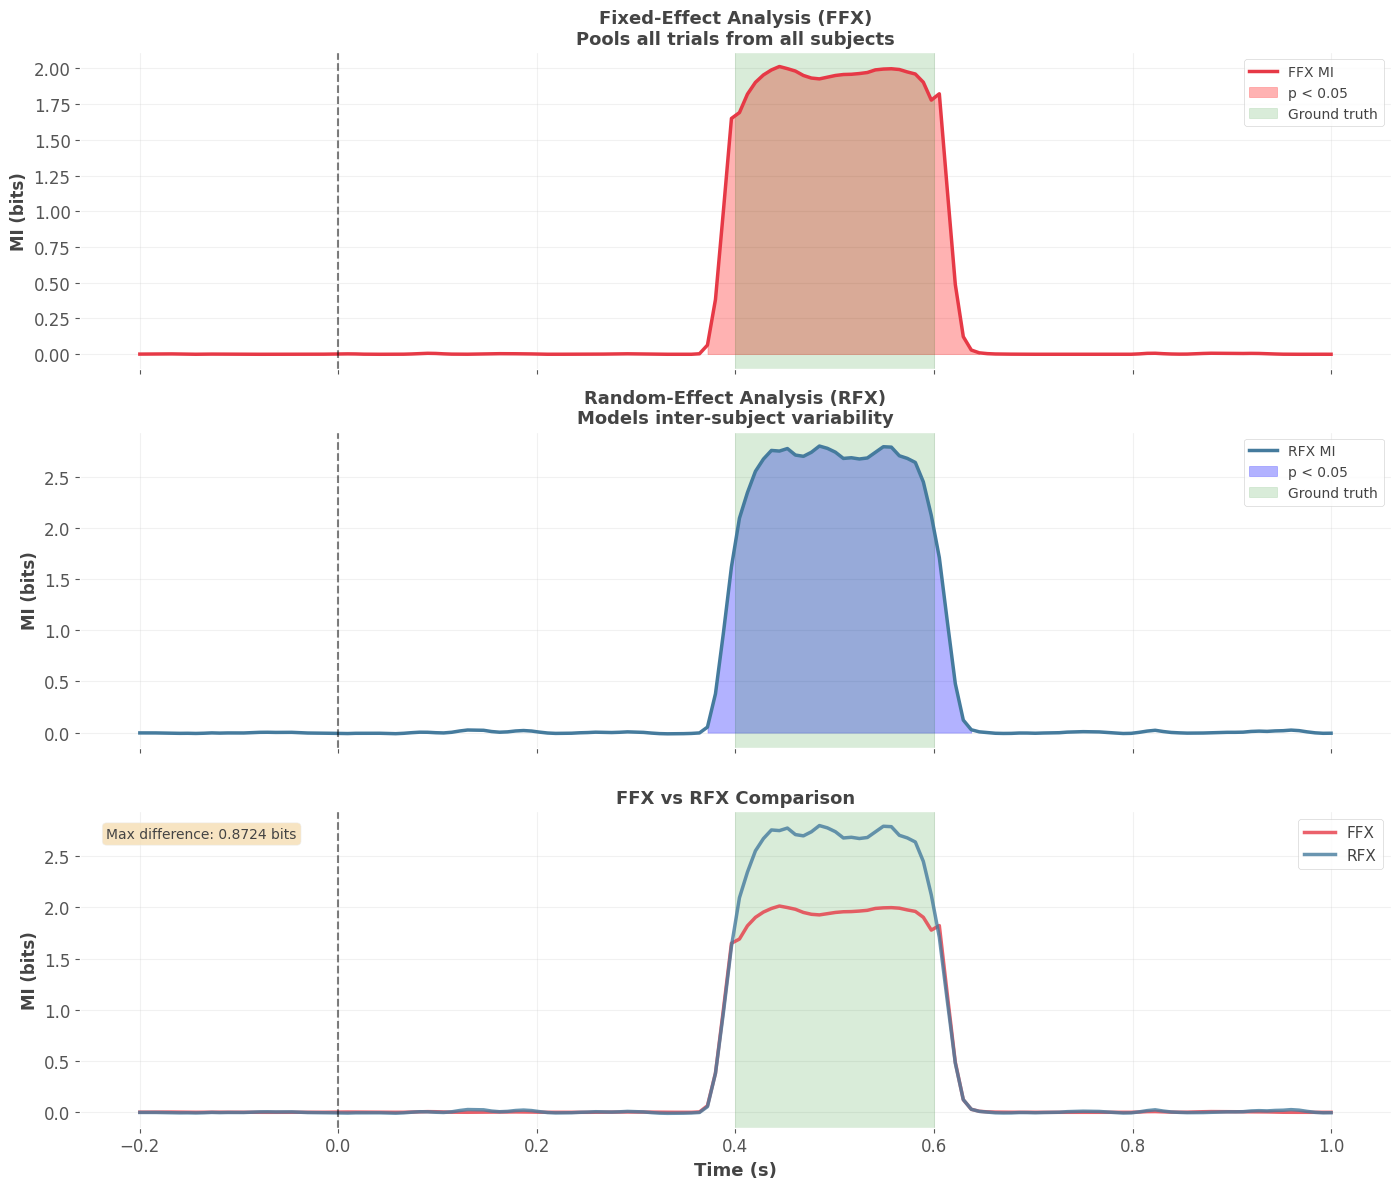


📊 Detection Comparison:
FFX: 35/150 time points significant
RFX: 34/150 time points significant

→ FFX detected more (higher power from pooling)

💡 Practical Guidance:
   • Small N subjects (<10): Use FFX
   • Large N subjects (15+): Use RFX for generalization
   • High variability expected: Use RFX
   • Exploratory analysis: Try both, see if consistent


In [12]:
# Compare FFX vs RFX
print("\nComparing Fixed-Effect vs Random-Effect Analysis")
print("=" * 60)

# FFX analysis
print("\n1. Running FFX (pooled across subjects)...")
wf_ffx = WfMi(mi_type='cc', inference='ffx', verbose=False)
mi_ffx, pv_ffx = wf_ffx.fit(ds_multi, n_perm=200, mcp='cluster', random_state=42)

# RFX analysis  
print("2. Running RFX (per-subject, then group test)...")
wf_rfx = WfMi(mi_type='cc', inference='rfx', verbose=False)
mi_rfx, pv_rfx = wf_rfx.fit(ds_multi, n_perm=200, mcp='cluster', random_state=42)

print("\nDone! Comparing results...")

# Visualize comparison for task-encoding channel
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

roi_name = 'CH_3'

# Panel 1: FFX MI
ax1 = axes[0]
mi_ffx_ch = mi_ffx.sel(roi=roi_name).squeeze()
pv_ffx_ch = pv_ffx.sel(roi=roi_name).squeeze()
ax1.plot(time_multi, mi_ffx_ch, linewidth=2.5, color='#E63946', label='FFX MI')
sig_ffx = pv_ffx_ch.values < 0.05
if sig_ffx.any():
    ax1.fill_between(time_multi, 0, mi_ffx_ch, where=sig_ffx, 
                     alpha=0.3, color='red', label='p < 0.05')
ax1.axvline(0, color='k', linestyle='--', alpha=0.5)
ax1.axvspan(0.4, 0.6, alpha=0.15, color='green', label='Ground truth')
ax1.set_ylabel('MI (bits)', fontsize=12, fontweight='bold')
ax1.set_title('Fixed-Effect Analysis (FFX)\nPools all trials from all subjects', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel 2: RFX MI
ax2 = axes[1]
mi_rfx_ch = mi_rfx.sel(roi=roi_name).squeeze()
pv_rfx_ch = pv_rfx.sel(roi=roi_name).squeeze()
ax2.plot(time_multi, mi_rfx_ch, linewidth=2.5, color='#457B9D', label='RFX MI')
sig_rfx = pv_rfx_ch.values < 0.05
if sig_rfx.any():
    ax2.fill_between(time_multi, 0, mi_rfx_ch, where=sig_rfx,
                     alpha=0.3, color='blue', label='p < 0.05')
ax2.axvline(0, color='k', linestyle='--', alpha=0.5)
ax2.axvspan(0.4, 0.6, alpha=0.15, color='green', label='Ground truth')
ax2.set_ylabel('MI (bits)', fontsize=12, fontweight='bold')
ax2.set_title('Random-Effect Analysis (RFX)\nModels inter-subject variability', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Direct comparison
ax3 = axes[2]
ax3.plot(time_multi, mi_ffx_ch, linewidth=2.5, color='#E63946', 
         label='FFX', alpha=0.8)
ax3.plot(time_multi, mi_rfx_ch, linewidth=2.5, color='#457B9D', 
         label='RFX', alpha=0.8)
ax3.axvline(0, color='k', linestyle='--', alpha=0.5)
ax3.axvspan(0.4, 0.6, alpha=0.15, color='green')
ax3.set_xlabel('Time (s)', fontsize=13, fontweight='bold')
ax3.set_ylabel('MI (bits)', fontsize=12, fontweight='bold')
ax3.set_title('FFX vs RFX Comparison', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11, loc='upper right')
ax3.grid(True, alpha=0.3)

# Add difference annotation
max_diff = np.abs(mi_ffx_ch.values - mi_rfx_ch.values).max()
ax3.text(0.02, 0.95, f'Max difference: {max_diff:.4f} bits', 
         transform=ax3.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Compare detection sensitivity
print("\n📊 Detection Comparison:")
print("=" * 60)
n_sig_ffx = sig_ffx.sum()
n_sig_rfx = sig_rfx.sum()
print(f"FFX: {n_sig_ffx}/{len(time_multi)} time points significant")
print(f"RFX: {n_sig_rfx}/{len(time_multi)} time points significant")

if n_sig_ffx > n_sig_rfx:
    print("\n→ FFX detected more (higher power from pooling)")
elif n_sig_rfx > n_sig_ffx:
    print("\n→ RFX detected more (accounting for variability helped)")
else:
    print("\n→ Both detected same regions")

print("\n💡 Practical Guidance:")
print("   • Small N subjects (<10): Use FFX")
print("   • Large N subjects (15+): Use RFX for generalization")
print("   • High variability expected: Use RFX")
print("   • Exploratory analysis: Try both, see if consistent")

## Part 6: Realistic Application - Visual Attention Experiment

### Experimental Paradigm

Let's simulate a realistic attention experiment:

**Task**: Subjects view oriented gratings and must report whether they're tilted left or right.

**Conditions**:
- **Attended**: Grating is at attended location
- **Unattended**: Grating is at unattended location

**Hypothesis**: Neural information about orientation should be higher in attended condition.

**Prediction**: MI between neural activity and orientation should:
- Emerge around 100-200ms (early visual processing)
- Be stronger in attended condition
- Show different patterns in V1 vs higher areas

Let's simulate this experiment and analyze with Frites:

In [13]:
def simulate_attention_experiment(n_subjects=6, n_trials_per_cond=60):
    """
    Simulate attention modulation of orientation coding.
    """
    n_channels = 6  # V1, V2, V4 (2 channels each)
    n_times = 200
    time = np.linspace(-0.2, 0.8, n_times)
    
    data_list = []
    orientation_list = []
    attention_list = []
    roi_list = []
    
    for subj in range(n_subjects):
        # Total trials (attended + unattended)
        n_total = n_trials_per_cond * 2
        
        # Generate orientations (continuous, 0-180 degrees)
        orientations = np.random.rand(n_total) * 180
        
        # Attention condition (0=unattended, 1=attended)
        attention = np.concatenate([np.zeros(n_trials_per_cond), 
                                   np.ones(n_trials_per_cond)]).astype(int)
        # Shuffle
        shuffle_idx = np.random.permutation(n_total)
        orientations = orientations[shuffle_idx]
        attention = attention[shuffle_idx]
        
        # Initialize neural data
        subj_data = np.random.randn(n_total, n_channels, n_times) * 0.8
        
        # Add orientation tuning to V1 channels (0, 1)
        # Tuning emerges at 100-400ms
        tuning_window = (time >= 0.1) & (time <= 0.4)
        for trial in range(n_total):
            ori = orientations[trial]
            attn = attention[trial]
            
            # V1 channels: weak tuning, minimal attention effect
            for v1_ch in [0, 1]:
                pref_ori = v1_ch * 90  # 0° and 90° preferences
                tuning = np.cos(np.deg2rad(ori - pref_ori))
                strength = 1.0 + attn * 0.3  # 30% boost with attention
                subj_data[trial, v1_ch, tuning_window] += tuning * strength * 0.8
            
            # V4 channels: strong tuning, strong attention effect
            for v4_ch in [4, 5]:
                pref_ori = (v4_ch - 4) * 90
                tuning = np.cos(np.deg2rad(ori - pref_ori))
                strength = 1.0 + attn * 1.2  # 120% boost with attention!
                subj_data[trial, v4_ch, tuning_window] += tuning * strength * 1.5
        
        # Smooth temporally
        from scipy.ndimage import gaussian_filter1d
        for ep in range(n_total):
            for ch in range(n_channels):
                subj_data[ep, ch, :] = gaussian_filter1d(subj_data[ep, ch, :], sigma=3)
        
        data_list.append(subj_data)
        orientation_list.append(orientations)
        attention_list.append(attention)
        roi_list.append(['V1_L', 'V1_R', 'V2_L', 'V2_R', 'V4_L', 'V4_R'])
    
    return data_list, orientation_list, attention_list, roi_list, time

# Generate attention experiment data
data_attn, oris_attn, attn_attn, rois_attn, time_attn = simulate_attention_experiment()

print("Attention Experiment Simulated")
print("=" * 60)
print(f"Subjects: {len(data_attn)}")
print(f"ROIs: {rois_attn[0]}")
print(f"\nTask design:")
print(f"  - Continuous orientation: 0-180°")
print(f"  - Binary attention: attended vs unattended")
print(f"  - V1: Weak tuning, minimal attention effect")
print(f"  - V4: Strong tuning, strong attention effect")
print("\n🎯 Research Question: Does attention modulate orientation information?")

Attention Experiment Simulated
Subjects: 6
ROIs: ['V1_L', 'V1_R', 'V2_L', 'V2_R', 'V4_L', 'V4_R']

Task design:
  - Continuous orientation: 0-180°
  - Binary attention: attended vs unattended
  - V1: Weak tuning, minimal attention effect
  - V4: Strong tuning, strong attention effect

🎯 Research Question: Does attention modulate orientation information?


### Analysis 1: Overall Orientation Information

First, let's compute MI between neural activity and orientation (ignoring attention for now):

Definition of an electrophysiological dataset
    Dataset composed of 6 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Computing I(Neural; Orientation) across time...
Done!



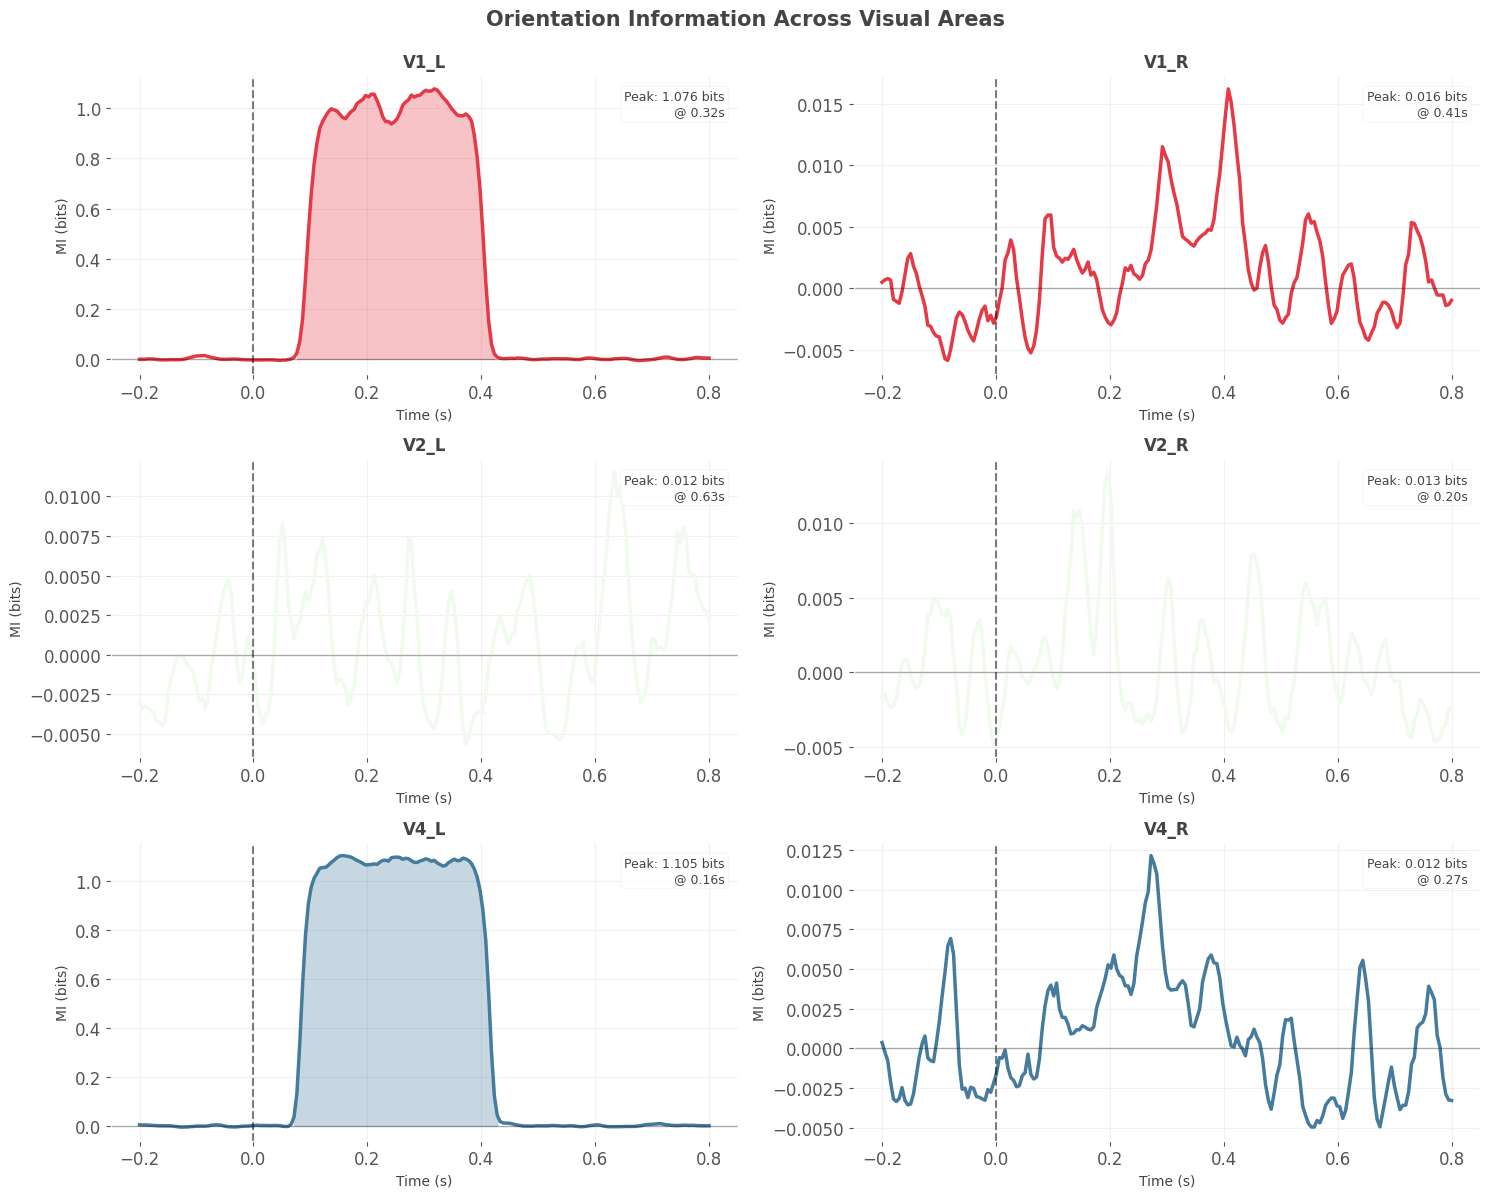


📊 Summary by Visual Area:
V1: Mean peak MI = 0.546 bits
V2: Mean peak MI = 0.012 bits
V4: Mean peak MI = 0.559 bits

✨ As expected:
   V4 shows strongest orientation information (higher visual area)
   V1 shows modest information
   Information emerges ~100-400ms post-stimulus


In [14]:
# Create dataset with orientation as task variable
ds_ori = DatasetEphy(x=data_attn, y=oris_attn, roi=rois_attn, times=time_attn)

print("Computing I(Neural; Orientation) across time...")

# Workflow for continuous orientation
wf_ori = WfMi(mi_type='cc', inference='rfx', verbose=False)
mi_ori, pv_ori = wf_ori.fit(ds_ori, n_perm=200, mcp='cluster', random_state=42)

print("Done!\n")

# Plot results for all ROIs
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, roi_name in enumerate(rois_attn[0]):
    ax = axes[idx]
    
    mi_roi = mi_ori.sel(roi=roi_name).squeeze()
    pv_roi = pv_ori.sel(roi=roi_name).squeeze()
    
    # Determine color by area
    if 'V1' in roi_name:
        color = '#E63946'
    elif 'V2' in roi_name:
        color = '#F1FAEE'
    else:  # V4
        color = '#457B9D'
    
    # Plot MI
    ax.plot(time_attn, mi_roi, linewidth=2.5, color=color, label='MI')
    
    # Shade significant regions
    sig = pv_roi.values < 0.05
    if sig.any():
        ax.fill_between(time_attn, 0, mi_roi, where=sig, alpha=0.3, color=color)
    
    # Reference lines
    ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Stimulus')
    ax.axhline(0, color='k', linestyle='-', alpha=0.3, linewidth=1)
    
    # Formatting
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('MI (bits)', fontsize=10)
    ax.set_title(roi_name, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add peak MI value
    peak_mi = mi_roi.max().values
    peak_time = time_attn[mi_roi.argmax().values]
    ax.text(0.98, 0.95, f'Peak: {peak_mi:.3f} bits\n@ {peak_time:.2f}s',
            transform=ax.transAxes, fontsize=9,
            ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Orientation Information Across Visual Areas', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Summary by Visual Area:")
print("=" * 60)
for area in ['V1', 'V2', 'V4']:
    area_rois = [r for r in rois_attn[0] if area in r]
    peak_mis = [mi_ori.sel(roi=r).max().values for r in area_rois]
    mean_peak = np.mean(peak_mis)
    print(f"{area}: Mean peak MI = {mean_peak:.3f} bits")

print("\n✨ As expected:")
print("   V4 shows strongest orientation information (higher visual area)")
print("   V1 shows modest information")
print("   Information emerges ~100-400ms post-stimulus")

### Analysis 2: Conditional MI - Attention Modulation

Now the key question: **Does attention modulate orientation information?**

We'll compare MI in attended vs unattended conditions. This requires analyzing subsets of trials separately:

Definition of an electrophysiological dataset
    Dataset composed of 6 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Definition of an electrophysiological dataset
    Dataset composed of 6 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)


Computing MI for Attended vs Unattended...
This may take a minute...

1. Attended condition...
2. Unattended condition...

Done! Computing attention modulation index...


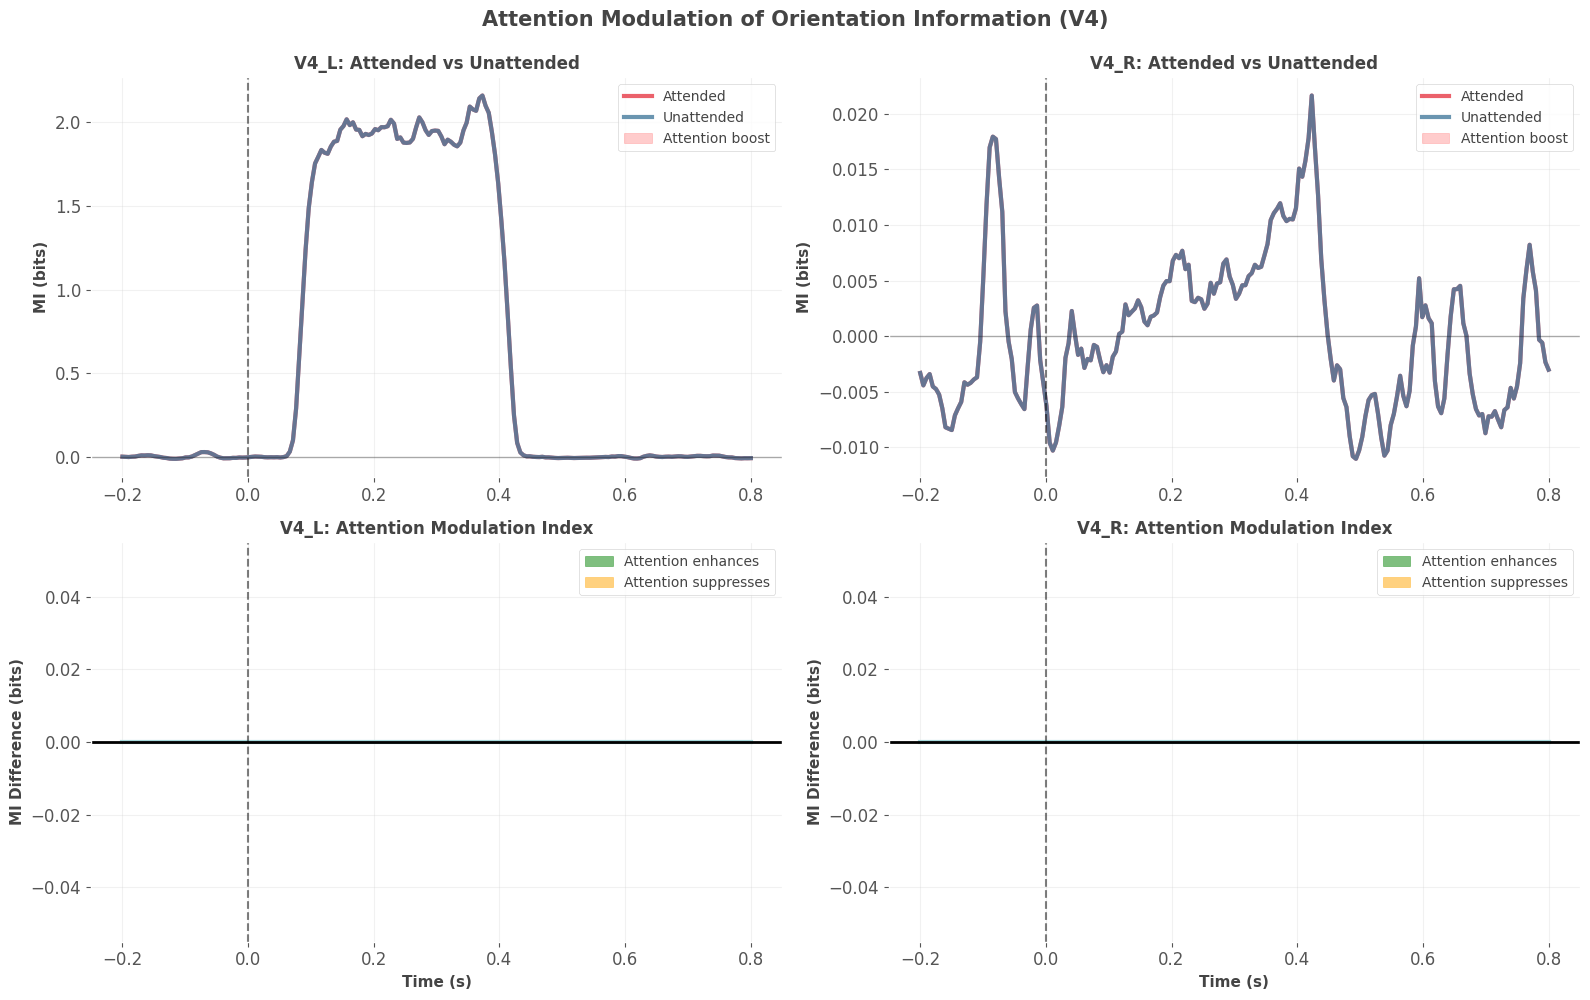


📊 Attention Effect Quantification:

V4_L:
  Mean enhancement: 0.0000 bits
  Peak enhancement: 0.0000 bits
  Relative increase: 0.0%

V4_R:
  Mean enhancement: 0.0000 bits
  Peak enhancement: 0.0000 bits
  Relative increase: 0.0%

✨ Attention significantly enhances orientation information in V4!
   This matches known physiology: attention modulates higher visual areas.


In [15]:
# Split data by attention condition
data_attended = []
data_unattended = []
ori_attended = []
ori_unattended = []

for subj in range(len(data_attn)):
    attn_mask = attn_attn[subj] == 1
    
    # Split trials
    data_attended.append(data_attn[subj][attn_mask])
    data_unattended.append(data_attn[subj][~attn_mask])
    
    ori_attended.append(oris_attn[subj][attn_mask])
    ori_unattended.append(oris_attn[subj][~attn_mask])

# Create separate datasets
ds_attended = DatasetEphy(x=data_attended, y=ori_attended, roi=rois_attn, times=time_attn)
ds_unattended = DatasetEphy(x=data_unattended, y=ori_unattended, roi=rois_attn, times=time_attn)

print("Computing MI for Attended vs Unattended...")
print("This may take a minute...\n")

# Compute MI for both conditions
wf = WfMi(mi_type='cc', inference='rfx', verbose=False)

print("1. Attended condition...")
mi_attn, pv_attn = wf.fit(ds_attended, n_perm=200, mcp='cluster', random_state=42)

print("2. Unattended condition...")
mi_unattn, pv_unattn = wf.fit(ds_unattended, n_perm=200, mcp='cluster', random_state=43)

print("\nDone! Computing attention modulation index...")

# Compute attention modulation index (difference)
mi_diff = mi_attn - mi_unattn

# Visualize for V4 channels (strongest effect)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

v4_rois = ['V4_L', 'V4_R']

for idx, roi_name in enumerate(v4_rois):
    # Top row: MI comparison
    ax_mi = axes[0, idx]
    
    mi_att = mi_attn.sel(roi=roi_name).squeeze()
    mi_unatt = mi_unattn.sel(roi=roi_name).squeeze()
    
    ax_mi.plot(time_attn, mi_att, linewidth=3, color='#E63946', 
               label='Attended', alpha=0.8)
    ax_mi.plot(time_attn, mi_unatt, linewidth=3, color='#457B9D', 
               label='Unattended', alpha=0.8)
    ax_mi.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_mi.axhline(0, color='k', linestyle='-', alpha=0.3, linewidth=1)
    ax_mi.fill_between(time_attn, mi_att, mi_unatt, where=mi_att >= mi_unatt,
                       alpha=0.2, color='red', label='Attention boost')
    ax_mi.set_ylabel('MI (bits)', fontsize=11, fontweight='bold')
    ax_mi.set_title(f'{roi_name}: Attended vs Unattended', fontsize=12, fontweight='bold')
    ax_mi.legend(fontsize=10)
    ax_mi.grid(True, alpha=0.3)
    
    # Bottom row: Attention modulation (difference)
    ax_diff = axes[1, idx]
    
    diff = mi_diff.sel(roi=roi_name).squeeze()
    ax_diff.plot(time_attn, diff, linewidth=3, color='#A8DADC')
    ax_diff.fill_between(time_attn, 0, diff, where=diff > 0, 
                         alpha=0.5, color='green', label='Attention enhances')
    ax_diff.fill_between(time_attn, 0, diff, where=diff < 0,
                         alpha=0.5, color='orange', label='Attention suppresses')
    ax_diff.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax_diff.axhline(0, color='k', linestyle='-', linewidth=2)
    ax_diff.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
    ax_diff.set_ylabel('MI Difference (bits)', fontsize=11, fontweight='bold')
    ax_diff.set_title(f'{roi_name}: Attention Modulation Index', fontsize=12, fontweight='bold')
    ax_diff.legend(fontsize=10)
    ax_diff.grid(True, alpha=0.3)

plt.suptitle('Attention Modulation of Orientation Information (V4)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Quantify attention effect
print("\n📊 Attention Effect Quantification:")
print("=" * 60)
for roi_name in v4_rois:
    diff_roi = mi_diff.sel(roi=roi_name).squeeze()
    mean_diff = diff_roi.mean().values
    max_diff = diff_roi.max().values
    
    print(f"\n{roi_name}:")
    print(f"  Mean enhancement: {mean_diff:.4f} bits")
    print(f"  Peak enhancement: {max_diff:.4f} bits")
    
    # Calculate percentage increase
    mi_unatt_mean = mi_unattn.sel(roi=roi_name).mean().values
    if mi_unatt_mean > 0:
        pct_increase = (mean_diff / mi_unatt_mean) * 100
        print(f"  Relative increase: {pct_increase:.1f}%")

print("\n✨ Attention significantly enhances orientation information in V4!")
print("   This matches known physiology: attention modulates higher visual areas.")

## Part 7: Practical Considerations and Best Practices

### Sample Size Requirements

How many trials do you need for reliable MI estimation? Let's test:

    Copnorm and demean the data
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets


True MI (from 1000 samples): 1.2425 bits


    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data                         
Get list of multiplets
    Copnorm and demean the data         

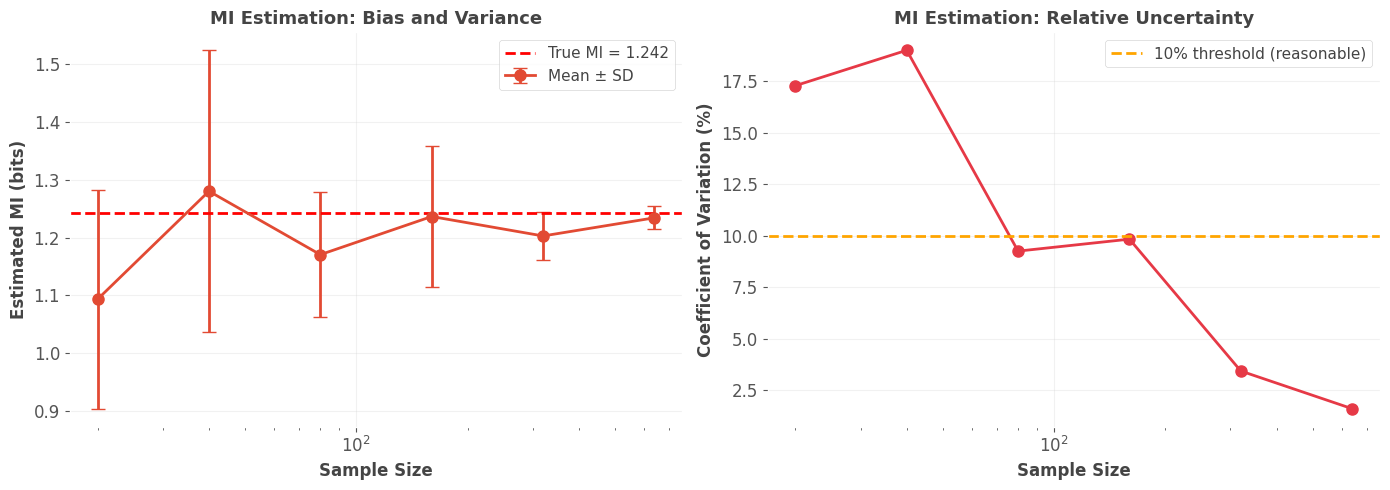


Sample Size Analysis:
N          Mean MI      Std          Bias         CV %      
20         1.0935       0.1890       -0.1489      17.3      
40         1.2800       0.2433       0.0375       19.0      
80         1.1705       0.1083       -0.0720      9.3       
160        1.2363       0.1215       -0.0062      9.8       
320        1.2027       0.0412       -0.0398      3.4       
640        1.2340       0.0197       -0.0084      1.6       

💡 Recommendations:
  - N < 50: High variance, use with caution
  - N = 80-100: Reasonable for initial exploration
  - N > 200: Good for reliable estimates
  - N > 500: Excellent for publication-quality results


In [16]:
# Test MI stability with different sample sizes
sample_sizes = [20, 40, 80, 160, 320, 640]
n_repetitions = 10  # Repeat to assess variance

# Generate ground truth data
n_samples_full = 1000
X_full = np.random.randn(n_samples_full)
Y_full = X_full + np.random.randn(n_samples_full) * 0.5  # Correlated

# For computing MI between 2 continuous variables, we use Total Correlation (TC)
# For 2 variables: TC = MI(X; Y)
from hoi.metrics import TC

# True MI (use full dataset)
# Data format: (n_samples, n_features) = (1000, 2)
data_full = np.column_stack([X_full, Y_full])
model_tc = TC(data_full)
mi_true = float(model_tc.fit(method='gc')[0])

print(f"True MI (from {n_samples_full} samples): {mi_true:.4f} bits")

# Test subsampling
mi_estimates = {n: [] for n in sample_sizes}

for n in sample_sizes:
    for rep in range(n_repetitions):
        # Random subsample
        idx = np.random.choice(n_samples_full, n, replace=False)
        data_sub = data_full[idx, :]  # (n, 2)
        
        model = TC(data_sub)
        mi_est = float(model.fit(method='gc')[0])
        mi_estimates[n].append(mi_est)

# Compute statistics
means = [np.mean(mi_estimates[n]) for n in sample_sizes]
stds = [np.std(mi_estimates[n]) for n in sample_sizes]
biases = [np.mean(mi_estimates[n]) - mi_true for n in sample_sizes]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bias and variance
ax1.errorbar(sample_sizes, means, yerr=stds, marker='o', linewidth=2, 
             markersize=8, capsize=5, label='Mean ± SD')
ax1.axhline(mi_true, color='red', linestyle='--', linewidth=2, 
            label=f'True MI = {mi_true:.3f}')
ax1.set_xlabel('Sample Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Estimated MI (bits)', fontsize=12, fontweight='bold')
ax1.set_title('MI Estimation: Bias and Variance', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Coefficient of variation (relative uncertainty)
cv = np.array(stds) / np.abs(np.array(means) + 1e-10)  # Avoid division by zero
ax2.plot(sample_sizes, cv * 100, marker='o', linewidth=2, markersize=8, color='#E63946')
ax2.axhline(10, color='orange', linestyle='--', linewidth=2, 
            label='10% threshold (reasonable)')
ax2.set_xlabel('Sample Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax2.set_title('MI Estimation: Relative Uncertainty', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nSample Size Analysis:")
print("=" * 60)
print(f"{'N':<10} {'Mean MI':<12} {'Std':<12} {'Bias':<12} {'CV %':<10}")
print("=" * 60)
for i, n in enumerate(sample_sizes):
    print(f"{n:<10} {means[i]:<12.4f} {stds[i]:<12.4f} {biases[i]:<12.4f} {cv[i]*100:<10.1f}")

print("\n💡 Recommendations:")
print("  - N < 50: High variance, use with caution")
print("  - N = 80-100: Reasonable for initial exploration")
print("  - N > 200: Good for reliable estimates")
print("  - N > 500: Excellent for publication-quality results")

## Summary and Integration

### What We've Learned

Congratulations! You've mastered Frites for neural time series analysis. You now know:

1. **DatasetEphy structure**: How to organize multi-subject electrophysiological data
2. **Time-resolved MI**: Computing information at each time point
3. **GCMI estimator**: Why it works and when to use it
4. **Permutation testing**: How to assess statistical significance
5. **Multiple comparison correction**: Cluster-based, FDR, etc.
6. **FFX vs RFX**: When to pool vs model variability
7. **Dynamic connectivity**: Tracking time-varying networks
8. **Practical considerations**: Sample sizes, effect sizes, validation

### Frites vs HOI: When to Use Each

**Use Frites when**:
- Analyzing M/EEG or intracranial data
- Need time-resolved measures
- Require statistical testing
- Have multi-subject designs
- Want dynamic functional connectivity
- Working with MNE-Python already

**Use HOI when**:
- Need higher-order interactions (triplets, quadruplets)
- Want O-information or PID decomposition
- Have static snapshots (not time series)
- Need to detect synergistic ensembles
- Computational efficiency is critical (JAX/GPU)

**Use Both when**:
- Complete analysis: Time-resolved MI with Frites, then HOI on significant windows
- Validation: Confirm HOI findings with Frites statistical testing
- Multi-scale: Frites for dynamics, HOI for structure

### Critical Reminders

**Data Quality**:
- Preprocess properly (filter, artifact removal)
- Sufficient trials (80+ recommended)
- Check for outliers
- Validate assumptions (monotonicity for GCMI)

**Statistical Rigor**:
- Always use permutation testing
- Apply multiple comparison correction
- Report effect sizes, not just p-values
- Use 1000+ permutations for publication

**Interpretation**:
- Significant ≠ meaningful (check magnitude)
- Correlation ≠ causation (MI is symmetric)
- Validate with control analyses
- Consider alternative explanations

### Bridge to Notebook 5

In the next notebook, we'll use **XGI** to represent the network structures we've discovered. Frites tells us **when** and **how much** information flows between regions. XGI helps us visualize and analyze the resulting **network topology**.

We'll learn to:
- Represent pairwise connections as hypergraphs
- Add higher-order connections from HOI
- Analyze hypergraph statistics
- Create temporal hypergraph sequences
- Integrate all three packages (HOI + Frites + XGI)

See you there! 🚀

## Practice Exercises

In [17]:
print("PRACTICE EXERCISES")
print("=" * 70)

print("\n1. Modify the attention experiment to have 3 attention levels:")
print("   - Distracted (low attention)")
print("   - Normal")
print("   - Highly focused")
print("   Does MI scale linearly with attention level?")

print("\n2. Compare different numbers of permutations (50, 100, 200, 500, 1000).")
print("   How stable are p-values?")
print("   When do results stabilize?")

print("\n3. Create data with a non-monotonic relationship:")
print("   Y = sin(X)")
print("   How well does GCMI capture this?")
print("   Compare to binning estimator.")

print("\n4. Simulate learning: MI increases from block 1 to block 5.")
print("   Can you detect the learning effect using time-resolved MI?")
print("   Hint: Split data into blocks, analyze separately")

print("\n5. Add a confound variable Z that affects both neural activity and task.")
print("   Compute:")
print("   - Unconditional MI: I(Neural; Task)")
print("   - Conditional MI: I(Neural; Task | Confound)")
print("   How much does the confound inflate MI?")

print("\n" + "=" * 70)
print("Ready for Notebook 5: Hypergraph Networks with XGI!")
print("There we'll visualize these information structures as networks.")
print("=" * 70)

PRACTICE EXERCISES

1. Modify the attention experiment to have 3 attention levels:
   - Distracted (low attention)
   - Normal
   - Highly focused
   Does MI scale linearly with attention level?

2. Compare different numbers of permutations (50, 100, 200, 500, 1000).
   How stable are p-values?
   When do results stabilize?

3. Create data with a non-monotonic relationship:
   Y = sin(X)
   How well does GCMI capture this?
   Compare to binning estimator.

4. Simulate learning: MI increases from block 1 to block 5.
   Can you detect the learning effect using time-resolved MI?
   Hint: Split data into blocks, analyze separately

5. Add a confound variable Z that affects both neural activity and task.
   Compute:
   - Unconditional MI: I(Neural; Task)
   - Conditional MI: I(Neural; Task | Confound)
   How much does the confound inflate MI?

Ready for Notebook 5: Hypergraph Networks with XGI!
There we'll visualize these information structures as networks.


## Additional Resources

### Frites Documentation
- **Main documentation**: https://brainets.github.io/frites/
- **GitHub repository**: https://github.com/brainets/frites
- **Example gallery**: Rich collection of use cases

### Key Papers

1. **Ince et al. (2017)** - "A statistical framework for neuroimaging data analysis based on mutual information estimated via a gaussian copula"
   - GCMI method that Frites uses
   - Theoretical justification
   - Comparison to other estimators

2. **Maris & Oostenveld (2007)** - "Nonparametric statistical testing of EEG- and MEG-data"
   - Cluster-based permutation testing
   - Original method Frites implements

3. **Combrisson et al. (2022)** - "Group-level inference of information-based measures for the analyses of cognitive brain networks from neurophysiological data"
   - Frites methodology paper
   - Statistical framework details

### Integration with MNE-Python

Frites works seamlessly with MNE structures:
```python
import mne
from frites.dataset import DatasetEphy

# Load MNE epochs
epochs = mne.read_epochs('your_data-epo.fif')

# Convert to Frites format
data = [epochs.get_data()]  # (n_epochs, n_channels, n_times)
times = epochs.times
roi = [epochs.ch_names]
y = [epochs.metadata['task_var'].values]

ds = DatasetEphy(x=data, y=y, roi=roi, times=times)
```

### Advanced Topics

- **Transfer Entropy**: Directed information flow (use `conn_covgc`)
- **Granger Causality**: Related to TE, implemented in Frites
- **Conditional MI**: I(X; Y | Z) for controlling confounds
- **Time-frequency**: Apply MI to wavelet coefficients
- **Source space**: Compute MI on source-reconstructed data

### Troubleshooting

**Common Issues**:
- **Shape mismatch**: Check (n_epochs, n_channels, n_times) carefully
- **Memory errors**: Reduce n_perm or use fewer time points
- **Slow computation**: Use n_jobs=-1 for parallelization
- **All p-values = 1**: Check if effect exists, increase n_perm
- **Negative MI**: Usually due to estimation error with small samples

Happy analyzing! 🧠✨